# Lab | Making predictions with logistic regression

In this lab, you will be using the Sakila database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented. We are asked to create a model to predict it. So we use the information we have from May 2005 to create the model.

## INSTRUCTIONS

### 1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features (X).


In [1]:
# prep: import modules and get pwd
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [2]:
# get the data
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''SELECT f.title, f.rental_rate, f.length, f.rating, r.rental_date, c.name as category
FROM film f
JOIN inventory i USING (film_id)
JOIN rental r USING (inventory_id)
JOIN film_category fc USING (film_id)
JOIN category c USING (category_id);'''

data = pd.read_sql_query(query, engine)
data.head()

,title,rental_rate,length,rating,rental_date,category
0,AMADEUS HOLY,0.99,113,PG,2005-08-02 01:16:59,Action
1,AMADEUS HOLY,0.99,113,PG,2005-08-18 04:26:54,Action
2,AMADEUS HOLY,0.99,113,PG,2005-06-20 20:35:28,Action
3,AMADEUS HOLY,0.99,113,PG,2005-07-09 05:01:58,Action
4,AMADEUS HOLY,0.99,113,PG,2005-07-30 08:02:39,Action


In [3]:
data.shape

(16045, 6)

### 2. Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) in May 2005. (Create new column called - 'rented_in_may'). This will be our TARGET (y) variable.

In [24]:
query = '''
SELECT f.film_id, f.title, f.release_year, f.language_id, f.rental_duration, f.rental_rate, f.length, f.rating, f.special_features,
COUNT(r.rental_id) AS num_rentals,
CASE WHEN COUNT(CASE WHEN r.rental_date BETWEEN '2005-05-01' AND '2005-05-31' THEN 1 END) > 0 THEN 1 ELSE 0 END AS rented_in_may
FROM film f
LEFT JOIN inventory i ON f.film_id = i.film_id
LEFT JOIN rental r ON i.inventory_id = r.inventory_id
GROUP BY f.film_id'''  

# as a result I have no distinguished between true or false an have 16045 rows 
data = pd.read_sql_query(query, engine)
data

,film_id,title,release_year,language_id,rental_duration,rental_rate,length,rating,special_features,num_rentals,rented_in_may
0,1,ACADEMY DINOSAUR,2006,1,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",24,1
1,2,ACE GOLDFINGER,2006,1,3,4.99,48,G,"Trailers,Deleted Scenes",7,0
2,3,ADAPTATION HOLES,2006,1,7,2.99,50,NC-17,"Trailers,Deleted Scenes",12,0
3,4,AFFAIR PREJUDICE,2006,1,5,2.99,117,G,"Commentaries,Behind the Scenes",23,1
4,5,AFRICAN EGG,2006,1,6,2.99,130,G,Deleted Scenes,12,1
...,...,...,...,...,...,...,...,...,...,...,...
995,996,YOUNG LANGUAGE,2006,1,6,0.99,183,G,"Trailers,Behind the Scenes",7,0
996,997,YOUTH KICK,2006,1,4,0.99,179,NC-17,"Trailers,Behind the Scenes",6,0
997,998,ZHIVAGO CORE,2006,1,6,0.99,105,NC-17,Deleted Scenes,9,1
998,999,ZOOLANDER FICTION,2006,1,5,2.99,101,R,"Trailers,Deleted Scenes",17,1


In [25]:
data.shape

(1000, 11)

### 3. Read the data into a Pandas dataframe. At this point you should have 1000 rows. Number of columns depends on the number of features you chose.

In [26]:
query = '''SELECT f.film_id, f.release_year, f.language_id, f.rental_duration, f.rental_rate, f.length, f.rating, 
COUNT(r.rental_id) AS num_rentals,
CASE WHEN COUNT(CASE WHEN r.rental_date BETWEEN '2005-05-01' AND '2005-05-31' THEN 1 END) > 0 THEN 1 ELSE 0 END AS rented_in_may
FROM film f
LEFT JOIN inventory i ON f.film_id = i.film_id
LEFT JOIN rental r ON i.inventory_id = r.inventory_id
GROUP BY f.film_id;'''

# as a result I get 1000 rows

# Is it requested to Alter table and ADD column? or just display
data = pd.read_sql_query(query, engine)
data.head()

,film_id,release_year,language_id,rental_duration,rental_rate,length,rating,num_rentals,rented_in_may
0,1,2006,1,6,0.99,86,PG,24,1
1,2,2006,1,3,4.99,48,G,7,0
2,3,2006,1,7,2.99,50,NC-17,12,0
3,4,2006,1,5,2.99,117,G,23,1
4,5,2006,1,6,2.99,130,G,12,1


### 4. Analyze extracted features (X) and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [27]:
data.dtypes

film_id              int64
release_year         int64
language_id          int64
rental_duration      int64
rental_rate        float64
length               int64
rating              object
num_rentals          int64
rented_in_may        int64
dtype: object

In [28]:
data.isna().sum()

film_id            0
release_year       0
language_id        0
rental_duration    0
rental_rate        0
length             0
rating             0
num_rentals        0
rented_in_may      0
dtype: int64

In [29]:
data.describe()

,film_id,release_year,language_id,rental_duration,rental_rate,length,num_rentals,rented_in_may
count,1000.000000,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,500.500000,2006.0,1.0,4.985000,2.980000,115.272000,16.04500,0.627000
std,288.819436,0.0,0.0,1.411654,1.646393,40.426332,7.34908,0.483844
min,1.000000,2006.0,1.0,3.000000,0.990000,46.000000,0.00000,0.000000
25%,250.750000,2006.0,1.0,4.000000,0.990000,80.000000,11.00000,0.000000
50%,500.500000,2006.0,1.0,5.000000,2.990000,114.000000,16.00000,1.000000
75%,750.250000,2006.0,1.0,6.000000,4.990000,149.250000,21.00000,1.000000
max,1000.000000,2006.0,1.0,7.000000,4.990000,185.000000,34.00000,1.000000


### 3. Analyze extracted features (X) and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [30]:
X_num = data.select_dtypes(include=np.number)
X_cat = data.select_dtypes(include=object)
y = data['rented_in_may']

In [31]:
X_cat

,rating
0,PG
1,G
2,NC-17
3,G
4,G
...,...
995,G
996,NC-17
997,NC-17
998,R


In [32]:
from sklearn.preprocessing import OneHotEncoder

X_cat = pd.get_dummies(X_cat, columns=['rating'], prefix=['rating'])
X_cat

,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0,0,1,0,0
1,1,0,0,0,0
2,0,1,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
995,1,0,0,0,0
996,0,1,0,0,0
997,0,1,0,0,0
998,0,0,0,0,1


In [33]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [34]:
minMax = MinMaxScaler()
minMax.fit(X_num)
X_minmax_scaled = minMax.transform(X_num)
X_minmax_scaled = pd.DataFrame(X_minmax_scaled,columns=X_num.columns)
X_minmax_scaled

,film_id,release_year,language_id,rental_duration,rental_rate,length,num_rentals,rented_in_may
0,0.000000,0.0,0.0,0.75,0.0,0.287770,0.705882,1.0
1,0.001001,0.0,0.0,0.00,1.0,0.014388,0.205882,0.0
2,0.002002,0.0,0.0,1.00,0.5,0.028777,0.352941,0.0
3,0.003003,0.0,0.0,0.50,0.5,0.510791,0.676471,1.0
4,0.004004,0.0,0.0,0.75,0.5,0.604317,0.352941,1.0
...,...,...,...,...,...,...,...,...
995,0.995996,0.0,0.0,0.75,0.0,0.985612,0.205882,0.0
996,0.996997,0.0,0.0,0.25,0.0,0.956835,0.176471,0.0
997,0.997998,0.0,0.0,0.75,0.0,0.424460,0.264706,1.0
998,0.998999,0.0,0.0,0.50,0.5,0.395683,0.500000,1.0


In [35]:
X = pd.concat([X_num, X_cat], axis=1)
X

,film_id,release_year,language_id,rental_duration,rental_rate,length,num_rentals,rented_in_may,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,1,2006,1,6,0.99,86,24,1,0,0,1,0,0
1,2,2006,1,3,4.99,48,7,0,1,0,0,0,0
2,3,2006,1,7,2.99,50,12,0,0,1,0,0,0
3,4,2006,1,5,2.99,117,23,1,1,0,0,0,0
4,5,2006,1,6,2.99,130,12,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,2006,1,6,0.99,183,7,0,1,0,0,0,0
996,997,2006,1,4,0.99,179,6,0,0,1,0,0,0
997,998,2006,1,6,0.99,105,9,1,0,1,0,0,0
998,999,2006,1,5,2.99,101,17,1,0,0,0,0,1


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

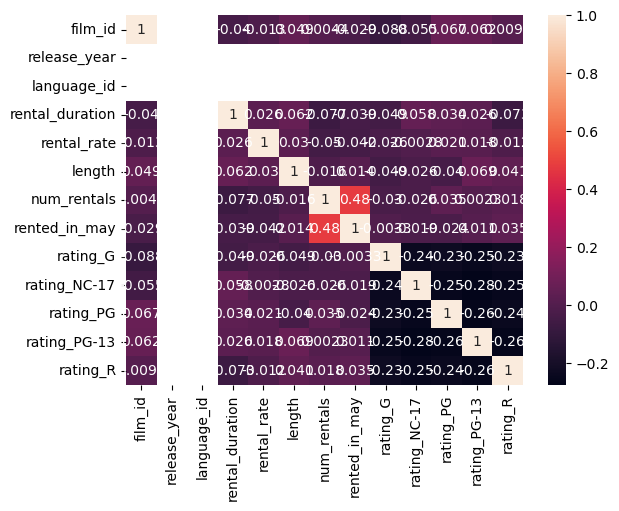

In [37]:
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [38]:
X.drop(['release_year', 'language_id'], axis=1)  

,film_id,rental_duration,rental_rate,length,num_rentals,rented_in_may,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,1,6,0.99,86,24,1,0,0,1,0,0
1,2,3,4.99,48,7,0,1,0,0,0,0
2,3,7,2.99,50,12,0,0,1,0,0,0
3,4,5,2.99,117,23,1,1,0,0,0,0
4,5,6,2.99,130,12,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
995,996,6,0.99,183,7,0,1,0,0,0,0
996,997,4,0.99,179,6,0,0,1,0,0,0
997,998,6,0.99,105,9,1,0,1,0,0,0
998,999,5,2.99,101,17,1,0,0,0,0,1


In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [41]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(750, 13)
(250, 13)
(750,)
(250,)


In [42]:
transformer = StandardScaler()
transformer.fit(X_train)

X_train_scaled_np = transformer.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled_np, columns=X_train.columns, index=X_train.index) 
X_test_scaled_np = transformer.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled_np , columns=X_test.columns, index=X_test.index)
X_train_scaled.head()

,film_id,release_year,language_id,rental_duration,rental_rate,length,num_rentals,rented_in_may,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
253,-0.827556,0.0,0.0,-0.688158,0.004865,1.095309,0.245837,0.774046,-0.457905,-0.508320,-0.474858,1.819435,-0.508320
667,0.600240,0.0,0.0,1.429975,1.221140,-0.864202,0.518788,0.774046,-0.457905,-0.508320,2.105892,-0.549621,-0.508320
85,-1.406951,0.0,0.0,0.723931,1.221140,0.152759,1.747065,0.774046,-0.457905,-0.508320,-0.474858,-0.549621,1.967265
969,1.641772,0.0,0.0,1.429975,-1.211410,-1.558712,1.337639,0.774046,-0.457905,1.967265,-0.474858,-0.549621,-0.508320
75,-1.441439,0.0,0.0,-0.688158,-1.211410,-0.293712,-0.982440,-1.291913,-0.457905,1.967265,-0.474858,-0.549621,-0.508320


### 5. Create a logistic regression model to predict 'rented_in_may' from the cleaned data.

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

In [59]:
lr = LogisticRegression(max_iter=250)
lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)

In [64]:
print("The accuracy of the model in the TEST set is: {:.2f}".format(lr.score(X_train_scaled, y_train)))
print("The precision in the TEST set is: {:.2f}".format(precision_score(y_train,y_pred_train, average='weighted')))
print("The recall in the TEST set is: {:.2f}".format(recall_score(y_train,y_pred_train, average='weighted')))
print("The F1 in the TEST set is: {:.2f}".format(f1_score(y_train,y_pred_train, average='weighted')))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))

The accuracy of the model in the TEST set is: 1.00
The precision in the TEST set is: 1.00
The recall in the TEST set is: 1.00
The F1 in the TEST set is: 1.00
The Kappa in the TEST set is: 1.00


In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

y_pred_test = lr.predict(X_test_scaled)

print("The accuracy of the model in the TEST set is: {:.2f}".format(lr.score(X_test_scaled, y_test)))
print("The precision in the TEST set is: {:.2f}".format(precision_score(y_test,y_pred_test, average='weighted')))
print("The recall in the TEST set is: {:.2f}".format(recall_score(y_test,y_pred_test, average='weighted')))
print("The F1 in the TEST set is: {:.2f}".format(f1_score(y_test,y_pred_test, average='weighted')))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))

The accuracy of the model in the TEST set is: 1.00
The precision in the TEST set is: 1.00
The recall in the TEST set is: 1.00
The F1 in the TEST set is: 1.00
The Kappa in the TEST set is: 1.00


In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

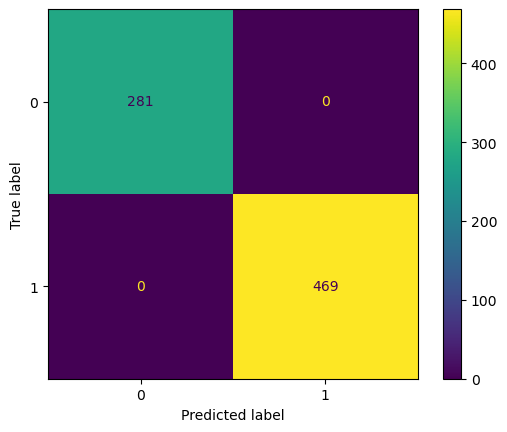

In [68]:
cm_test = confusion_matrix(y_train,y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=lr.classes_)
disp.plot()
plt.show()